In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

2025-05-09 08:38:48.568643: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-09 08:38:48.572158: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-09 08:38:48.581274: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746779928.595505   17329 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746779928.599738   17329 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746779928.613838   17329 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [3]:
# Load dataset
df = pd.read_csv("dataset.csv")

# Convert and sort date
df['Date'] = pd.to_datetime(df['Date'], utc=True)
df.sort_values('Date', inplace=True)

# Scale the 'Close' column
scaler = MinMaxScaler()
df['Scaled_Close'] = scaler.fit_transform(df[['Close']])

In [4]:
# Function to create sequences
def create_sequences(data, look_back=30):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back])
        y.append(data[i+look_back])
    return np.array(X), np.array(y)

# Set look-back window size
look_back = 30

# Generate input/output sequences
X, y = create_sequences(df['Scaled_Close'].values, look_back)

# Reshape for LSTM input: [samples, time steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

In [10]:
from tensorflow.keras import Input

# Define the LSTM model
model = Sequential([
    Input(shape=(look_back, 1)),
    LSTM(50, return_sequences=False),
    Dense(1)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [6]:
# Train the model
history = model.fit(X, y, epochs=20, batch_size=16, verbose=1)

Epoch 1/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0241
Epoch 2/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.9652e-04
Epoch 3/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.7082e-04
Epoch 4/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.8762e-04
Epoch 5/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.6259e-04
Epoch 6/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.3899e-04
Epoch 7/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.4754e-04
Epoch 8/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2246e-04
Epoch 9/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.7397e-04
Epoch 10/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2816e-04
Epoch 11/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6637e-04
Epoch 12/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2688e-04
Epoch 13/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6162e-04
Epoch 14/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9134e-04
Epoch 15/20
77/77 ━━━━━━━━━━━━━━━

In [7]:
# Predict on training data
y_pred_scaled = model.predict(X)

# Inverse transform predictions and actual values
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = scaler.inverse_transform(y.reshape(-1, 1)).flatten()

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [8]:
# Calculate metrics
rmse_score = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print("Root Mean Squared Error (RMSE):", rmse_score)
print("R² Score:", r2)

Root Mean Squared Error (RMSE): 30.4509348956052
R² Score: 0.9929158641060563


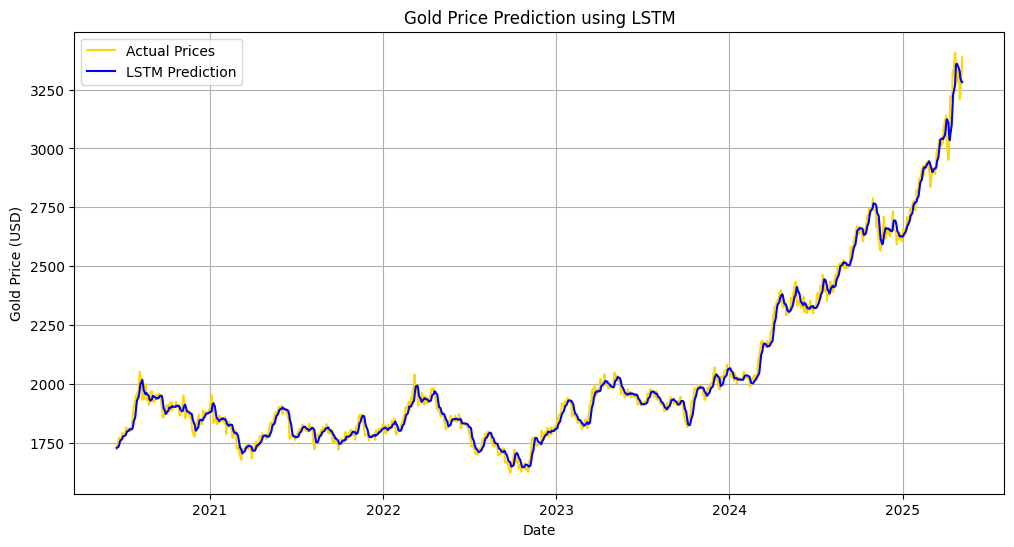

In [9]:
# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(df['Date'][look_back:], y_true, label='Actual Prices', color='gold')
plt.plot(df['Date'][look_back:], y_pred, label='LSTM Prediction', color='blue')
plt.xlabel('Date')
plt.ylabel('Gold Price (USD)')
plt.title('Gold Price Prediction using LSTM')
plt.legend()
plt.grid(True)
plt.show()